In [54]:
# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import csv
from torchvision import transforms
from sklearn.cluster import DBSCAN
import pandas as pd
from PIL import Image
from tools.solider import solider_result
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [55]:
def plot_mds(features_array="", image_names=[],simpleLegend=True, title="", figsize=(12,10), scaler=False):
    if len(features_array) == 0:
        print(f"Sin gráfico por no tener valores para {title}")
        return False
    if scaler:
        scaler = StandardScaler().fit(features_array)
        features_array = scaler.transform(features_array)
    # Apply MDS
    mds = MDS(n_components=2)
    mds_result = mds.fit_transform(features_array)
    
    # Extract prefix and suffix from image names for coloring
    prefixes = [int(name.split('_')[1]) for name in image_names]
    suffixes = [int(name.split('_')[2]) for name in image_names]
    max_suffix = max(suffixes)
    min_alpha = 0.6
    normalized_suffixes = [min_alpha + (1 - min_alpha) * (s / max_suffix) for s in suffixes]
    
    # Create a mapping of prefix to palette index
    unique_prefixes = list(set(prefixes))
    prefix_to_index = {prefix: i for i, prefix in enumerate(unique_prefixes)}
    added_to_legend = set()
    legend_handles_labels = []

    # Plotting
    plt.figure(figsize=figsize)
    palette = sns.color_palette("husl", len(unique_prefixes))
    for i, (x, y) in enumerate(mds_result):
        color = palette[prefix_to_index[prefixes[i]]]
        label = None
        if simpleLegend:
            if prefixes[i] not in added_to_legend:
                label = f"img_{prefixes[i]}"
                added_to_legend.add(prefixes[i])
        else:
            label = f"{image_names[i].split('_')[3][0]}{prefixes[i]}_{suffixes[i]}"
            added_to_legend.add(prefixes[i])
        plt.text(x, y, f"{prefixes[i]}_{suffixes[i]}", fontsize=8, ha='right', va='bottom')
        handle = plt.scatter(x, y, color=(color[0], color[1], color[2], normalized_suffixes[i]), label=label)

        if label:
            legend_handles_labels.append((handle, label))

    # Sort the handles and labels
    legend_handles_labels = sorted(legend_handles_labels, key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*legend_handles_labels)

    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.title(f"MDS {title}")
    plt.legend(handles=sorted_handles, labels=sorted_labels)
    plt.show()

def extract_images_from_subfolders(folder_paths):
    # If the input is a string (single folder path), convert it into a list
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]
    
    all_images = []
    
    for folder_path in folder_paths:
        # Walk through each main folder and its subfolders
        for dirpath, dirnames, filenames in os.walk(folder_path):
            # For each subfolder, find all .png images
            images = glob.glob(os.path.join(dirpath, '*.png'))
            all_images.extend(images)
    return all_images

def preprocess_image(img_path, heigth,width):
    transform = transforms.Compose([
        transforms.Resize((heigth, width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image)
    return image

def evaluate_clustering(features, image_names, num_clusters=2):
    """
    Evaluates the clustering performance using KMeans algorithm and returns the silhouette and 
    Davies-Bouldin scores, along with the clustered images.

    :param features: A 2D numpy array where each row represents the feature vector of an image.
    :param image_names: A list of image names corresponding to each feature vector.
    :param num_clusters: The number of clusters to form. Default is 2.
    :return: A tuple containing the silhouette score, Davies-Bouldin score, and a list of tuples with
             image names and their corresponding cluster labels.
    """
    # Create KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the model
    kmeans.fit(features)

    # Predict the cluster for each image
    cluster_labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(features, cluster_labels)

    # Calculate Davies-Bouldin score
    davies_bouldin_avg = davies_bouldin_score(features, cluster_labels)

    # Pairing image names with their respective cluster labels
    clustered_images = list(zip(image_names, cluster_labels))

    return silhouette_avg, davies_bouldin_avg#, clustered_images

def get_folders(parent_folder, limit=None):
    # List all entries in the parent folder
    parent_folder = os.path.abspath(parent_folder)
    entries = os.listdir(parent_folder)

    
    # Filter out the subfolders and get their full paths
    subfolder_paths = [os.path.join(parent_folder, entry) for entry in entries if os.path.isdir(os.path.join(parent_folder, entry))]
    
    # Sort the subfolders by their names converted to integers
    subfolder_paths.sort(key=lambda x: int(os.path.basename(x)))

    if limit is not None:
        return subfolder_paths[:limit]
    return subfolder_paths

def save_solider_csv(features_array, images_names, filename):
    # Ensure the filename ends with '.csv'
    if not filename.endswith('.csv'):
        filename += '.csv'

    # Check if the file exists to determine if we need to write headers
    file_exists = os.path.isfile(filename)

    # Open the file in append mode
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)

        # Write headers if the file is new
        if not file_exists:
            writer.writerow(['Name', 'ID', 'Direction'] + [f'Feature_{i+1}' for i in range(len(features_array[0]))])

        # Write data
        for image_name, features in zip(images_names, features_array):
            id = image_name.split('_')[1]
            direction = image_name.split('_')[3]
            feature_list = [str(f) for f in features]  # Convert features to a list of strings
            row_data = [image_name, id, direction] + feature_list
            writer.writerow(row_data)

def in_out_status(values):
    in_count = values.count('In')
    out_count = values.count('Out')

    # If all values are the same, return that value
    if in_count == len(values) or out_count == len(values):
        return values[0]

    # si existe 10 In y 2 Out entonces que sea In, pero si hay 3 Out ya no
    number_img_different_permited = 2
    

    if abs(in_count - out_count) >= len(values) - (2 * number_img_different_permited):
        return 'In' if in_count > out_count else 'Out'

    # If there are two or more elements that differ, return 'InOut'
    return 'InOut'

def chunk_array(array, chunk_size):
    chunks = []
    for i in range(0, len(array), chunk_size):
        chunks.append(array[i:i + chunk_size])
    return chunks

def plot_mds_dbscan(features_array="", image_names=[], plot=True, title="", figsize=(12, 10), eps=0.5, min_samples_ratio=0.15, min_include=3, scaler=True):
    if scaler:
        scaler = StandardScaler().fit(features_array)
        features_array = scaler.transform(features_array)
    # Apply MDS
    mds = MDS(n_components=2, random_state=42)
    mds_result = mds.fit_transform(features_array)
    
    count_image_cluster = pd.DataFrame({'images': image_names,'id': [img.split('_')[1] for img in image_names]}).groupby('id').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
    idcluster1 , sizecluster1 = count_image_cluster.iloc[0,0] , count_image_cluster.iloc[0,1]
    idcluster2 , sizecluster2 = count_image_cluster.iloc[1,0] , count_image_cluster.iloc[1,1]
    

    # Apply DBSCAN clustering
    min_samples = int(sizecluster1*min_samples_ratio)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(mds_result)
    labels = db.labels_

    
    ### DATA FRAME ####
    data_images = pd.DataFrame({'images': image_names,'id': [img.split('_')[1] for img in image_names],'labels': db.labels_})
    count_data = data_images[data_images.labels != -1].groupby('labels').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
    if len(count_data) == 0:
        return False, ''
    id_biggest_cluster_size = count_data.iloc[0,0]
    overlap_images = data_images[data_images.labels == id_biggest_cluster_size].groupby('id').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
    if len(overlap_images) > 1:
        if overlap_images.iloc[1,1] > min_include:
            total_images_inside_big_cluster = ', '.join([f"ID: {row[0]} Total: {row[1]}" for index,row in overlap_images.iloc[1:].reset_index(drop=True).iterrows()])
            msg = f"Total de imagenes {total_images_inside_big_cluster} encontradas en cluster ID: {idcluster1}  min_samples: {min_samples}"
            print(msg)
    ### DATA FRAME ####

    if plot:
        # Define a color palette for DBSCAN clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # excluding noise
        cluster_palette = sns.color_palette('husl', n_clusters)
        # Handle noise in the data
        colors = [(0.5, 0.5, 0.5) if label == -1 else cluster_palette[label] for label in labels]
        
        # Plotting
        plt.figure(figsize=figsize)
        for i, (x, y) in enumerate(mds_result):
            plt.text(x, y, f"{image_names[i]}", fontsize=8, ha='right', va='bottom')
            plt.scatter(x, y, color=colors[i], label=f'Cluster {labels[i]}' if labels[i] != -1 else 'Noise')

        plt.xlabel('MDS Dimension 1')
        plt.ylabel('MDS Dimension 2')
        plt.title(f"MDS/ DBSCAN eps {eps} min_samples {min_samples} {title}")
        
        # Create a legend for the clusters
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_palette[i], markersize=10) for i in range(n_clusters)]
        labels = [f'Cluster {i}' for i in range(n_clusters)]
        if -1 in labels:  # if there's noise
            handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(0.5, 0.5, 0.5), markersize=10))
            labels.append('Noise')
        plt.legend(handles=handles, labels=labels)
        plt.show()

#### Rapid Example between folder Solider + Plot

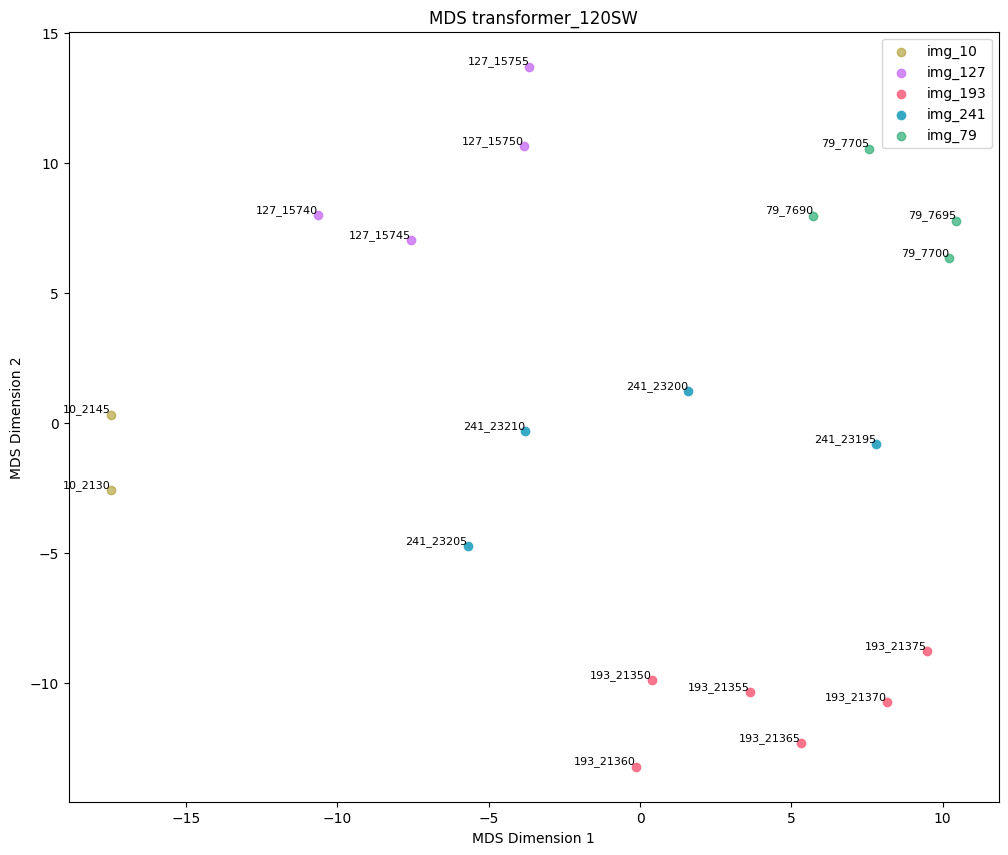

In [59]:
import torch
# Path to your saved model
model_path = 'solider_model.pth'


# Load the model
loaded_model = torch.load(model_path)
loaded_model.eval()  # Set the model to evaluation mode
# Assuming you have a function to preprocess your input data
# For example, preprocess_image() that takes an image and returns a tensor

people = [
    "in-out-backup/241",
    "in-out-backup/79",
    "in-out-backup/10",
    "in-out-backup/127",
    "in-out-backup/193",
]

images = extract_images_from_subfolders(people)

# Extract image names from paths
image_names = [os.path.splitext(os.path.basename(img_path))[0] for img_path in images]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
# Extract features
total_batch = [torch.stack([preprocess_image(img,384,128)], dim=0) for img in images]
with torch.no_grad():
    features_list, _ = loaded_model(torch.cat(total_batch,dim=0).to(device))

# Convert tensor to numpy array
features_array = features_list.cpu().numpy()
plot_mds(features_array=features_array, image_names=image_names,simpleLegend=True, title='transformer_120SW')
# evaluate_clustering(features_array, image_names, num_clusters=2)
# plot_mds_dbscan(features_array=features_array, image_names=image_names, plot=True, title='transformer_120SW', eps=0.5, min_samples_ratio=0.15, min_include=3, scaler=True)

In [ ]:
# features_array, image_names = solider_result(list_folders)




# save_solider_csv(features_array, image_names, 'solider_result')

#### Generate CSV Save Solider

In [ ]:
list_folders = get_folders("in-out-backup")

results = []
full_path = []
for folder in list_folders:
    entries = os.listdir(folder)
    list = [img.split('_')[3] for img in entries]
    in_or_out = in_out_status(list)
    if in_or_out != 'InOut':
        results.append(f"{folder.split('/')[-1]}: {in_or_out}")
        full_path.append(folder)

chuncks = chunk_array(full_path,40)

for chunck in chuncks:
    features_array, image_names = solider_result(chunck)
    save_solider_csv(features_array, image_names, 'solider_result')




#### Read CSV Solider and final Heatmap

/tmp/ipykernel_53355/1713578782.py:63: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  silhouette_avg = silhouette_avg.applymap(pd.to_numeric, errors='coerce')


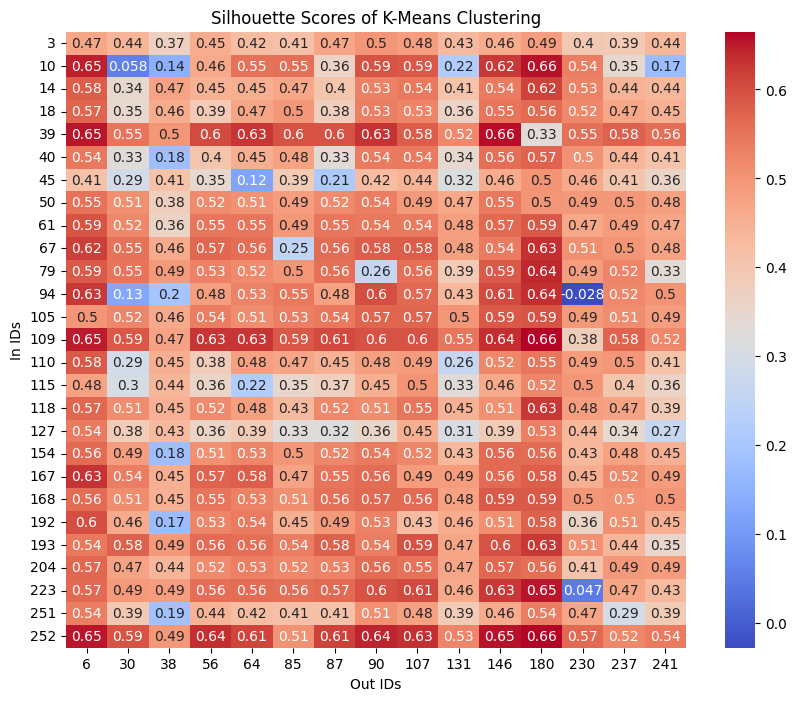

In [23]:
# Read CSV SOLIDER

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('solider_result.csv', nrows=200)

# Convert feature columns to floats
for col in df.columns[3:]:  # Adjust the index 3 based on your CSV structure
    df[col] = df[col].astype(float)

#df['ID'].groupby(df['ID']).count()



for id in df['ID'].unique():
    # Extract the array of directions for the current ID
    directions = df.loc[df['ID'] == id, 'Direction'].tolist()
    
    # Get the single value to replace with
    new_direction = in_out_status(directions)
    
    # Update the 'Direction' column for the current ID
    df.loc[df['ID'] == id, 'Direction'] = new_direction



# Separate 'In' and 'Out' data
df_in = df[df['Direction'] == 'In']
df_out = df[df['Direction'] == 'Out']

# Get unique IDs for 'In' and 'Out'
unique_ids_in = df_in['ID'].unique()
unique_ids_out = df_out['ID'].unique()

# Prepare the silhouette_avg DataFrame
silhouette_avg = pd.DataFrame(index=unique_ids_in, columns=unique_ids_out)

# Calculate K-means and silhouette scores for each pair of 'In' and 'Out' IDs
for id_in in unique_ids_in:
    for id_out in unique_ids_out:
        # Subset the data for the current pair of IDs
        data_in = df_in[df_in['ID'] == id_in].iloc[:, 3:]  # Adjust column index if needed
        data_out = df_out[df_out['ID'] == id_out].iloc[:, 3:]  # Adjust column index if needed
        
        # Make sure there is data to cluster
        if not data_in.empty and not data_out.empty:
            # Concatenate 'In' and 'Out' data for clustering
            data_cluster = pd.concat([data_in, data_out])
            
            # Perform K-means clustering with 2 clusters
            kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(data_cluster)
            
            # Calculate the silhouette score
            if len(data_cluster) > 1:  # Silhouette score requires at least 2 points
                score = silhouette_score(data_cluster, kmeans.labels_)
                silhouette_avg.at[id_in, id_out] = score

silhouette_avg = silhouette_avg.applymap(pd.to_numeric, errors='coerce')

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(silhouette_avg, annot=True, cmap='coolwarm')
plt.title('Silhouette Scores of K-Means Clustering')
plt.xlabel('Out IDs')
plt.ylabel('In IDs')
plt.show()



#### Read CSV Solider and final Heatmap DBSCAN

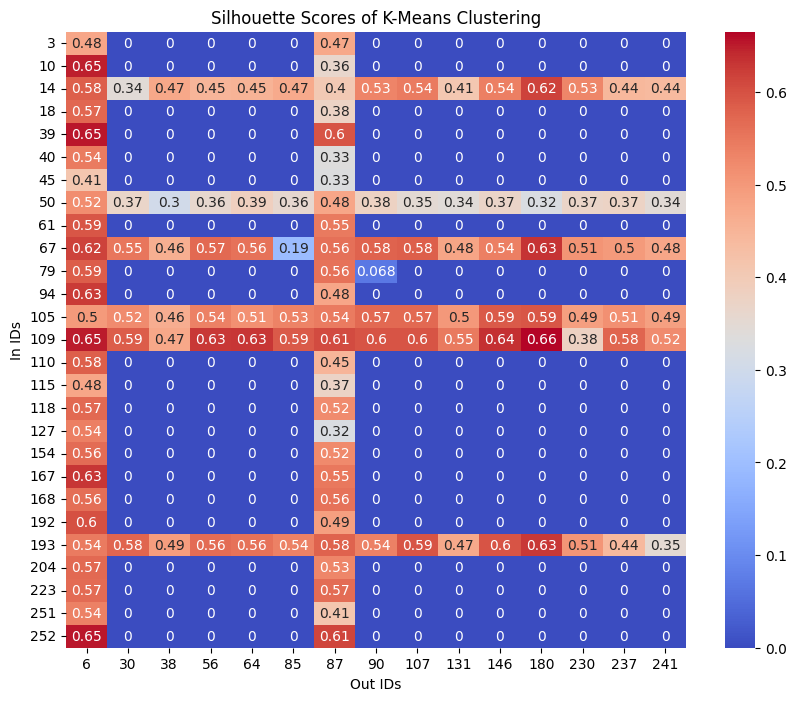

In [41]:
# Read CSV SOLIDER

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('solider_result.csv', nrows=200)

# Convert feature columns to floats
for col in df.columns[3:]:  # Adjust the index 3 based on your CSV structure
    df[col] = df[col].astype(float)

#df['ID'].groupby(df['ID']).count()



for id in df['ID'].unique():
    # Extract the array of directions for the current ID
    directions = df.loc[df['ID'] == id, 'Direction'].tolist()
    
    # Get the single value to replace with
    new_direction = in_out_status(directions)
    
    # Update the 'Direction' column for the current ID
    df.loc[df['ID'] == id, 'Direction'] = new_direction


# Separate 'In' and 'Out' data
df_in = df[df['Direction'] == 'In']
df_out = df[df['Direction'] == 'Out']

# Get unique IDs for 'In' and 'Out'
unique_ids_in = df_in['ID'].unique()
unique_ids_out = df_out['ID'].unique()

# Prepare the silhouette_avg DataFrame
silhouette_avg = pd.DataFrame(index=unique_ids_in, columns=unique_ids_out)


# Define DBSCAN parameters
# epsilon = 0.5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples = 5  # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point

epsilon = 10  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 5  # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point

# Calculate K-means and silhouette scores for each pair of 'In' and 'Out' IDs
for id_in in unique_ids_in:
    for id_out in unique_ids_out:
        # Subset the data for the current pair of IDs
        data_in = df_in[df_in['ID'] == id_in].iloc[:, 3:]  # Adjust column index if needed
        data_out = df_out[df_out['ID'] == id_out].iloc[:, 3:]  # Adjust column index if needed
        
        # Make sure there is data to cluster
        if not data_in.empty and not data_out.empty:
            data_cluster = pd.concat([data_in, data_out])

            # Perform DBSCAN clustering
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data_cluster)

            # Check if there are enough clusters and points for silhouette score
            if len(set(dbscan.labels_)) > 1 and len(data_cluster) > 1:
                score = silhouette_score(data_cluster, dbscan.labels_)
                silhouette_avg.at[id_in, id_out] = score

# silhouette_avg = silhouette_avg.applymap(pd.to_numeric, errors='coerce')
silhouette_avg = silhouette_avg.fillna(0)
# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(silhouette_avg, annot=True, cmap='coolwarm')
plt.title('Silhouette Scores of K-Means Clustering')
plt.xlabel('Out IDs')
plt.ylabel('In IDs')
plt.show()



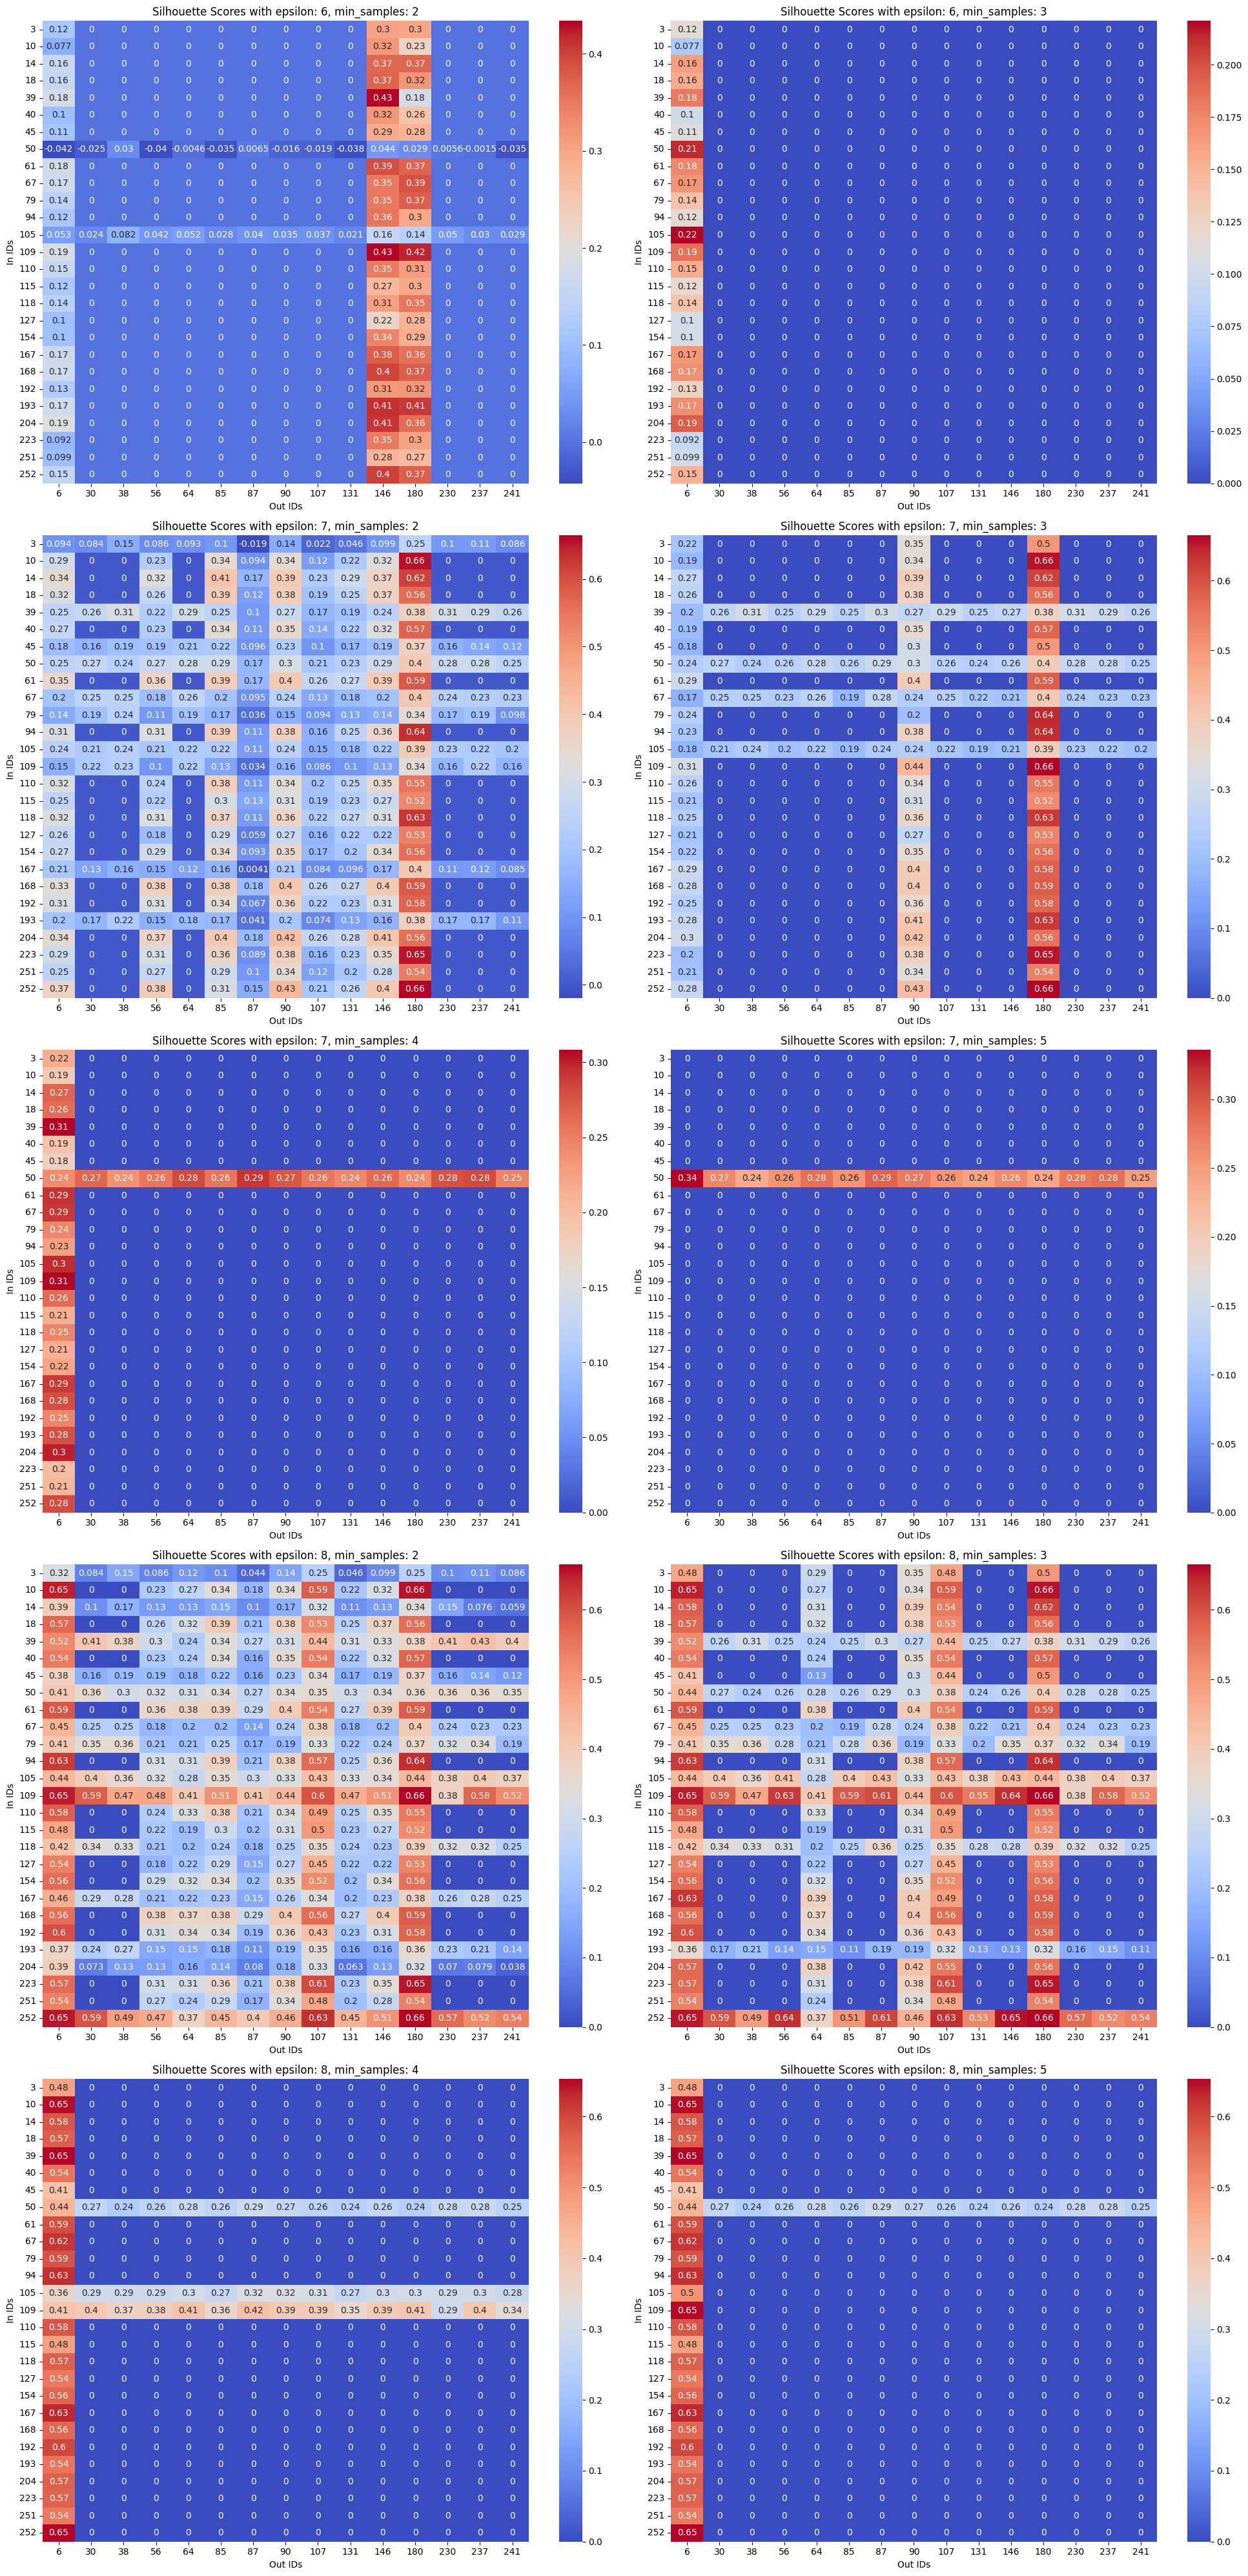

In [52]:
# Updated Code for Parameter Tuning DEBUG

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('solider_result.csv', nrows=200)

# Convert feature columns to floats
for col in df.columns[3:]:  # Adjust the index 3 based on your CSV structure
    df[col] = df[col].astype(float)

#df['ID'].groupby(df['ID']).count()

for id in df['ID'].unique():
    # Extract the array of directions for the current ID
    directions = df.loc[df['ID'] == id, 'Direction'].tolist()
    # Get the single value to replace with
    new_direction = in_out_status(directions)
    # Update the 'Direction' column for the current ID
    df.loc[df['ID'] == id, 'Direction'] = new_direction


# Separate 'In' and 'Out' data
df_in = df[df['Direction'] == 'In']
df_out = df[df['Direction'] == 'Out']

# Get unique IDs for 'In' and 'Out'
unique_ids_in = df_in['ID'].unique()
unique_ids_out = df_out['ID'].unique()


# Define the parameter ranges to test
epsilon_values = [6,7,8]  # Example range
min_samples_values = [2, 3, 4, 5]  # Example range

# Store subplots data
subplots_data = []

for eps in epsilon_values:
    for min_samples in min_samples_values:
        silhouette_avg = pd.DataFrame(index=unique_ids_in, columns=unique_ids_out)

        for id_in in unique_ids_in:
            for id_out in unique_ids_out:
                data_in = df_in[df_in['ID'] == id_in].iloc[:, 3:]
                data_out = df_out[df_out['ID'] == id_out].iloc[:, 3:]

                if not data_in.empty and not data_out.empty:
                    data_cluster = pd.concat([data_in, data_out])
                    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_cluster)

                    n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

                    if n_clusters > 0:
                        score = silhouette_score(data_cluster, dbscan.labels_)
                        silhouette_avg.at[id_in, id_out] = score

        # Add to subplots data if clusters were found
        if silhouette_avg.notnull().values.any():
            silhouette_avg = silhouette_avg.fillna(0)
            subplots_data.append((eps, min_samples, silhouette_avg))

# Determine the layout of the subplots
n_subplots = len(subplots_data)
n_cols = 2
n_rows = math.ceil(n_subplots / n_cols)

# Create the subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 8 * n_rows))

for i, (eps, min_samples, silhouette_avg) in enumerate(subplots_data):
    # Determine the current subplot's row and column
    row = i // n_cols
    col = i % n_cols
    
    if n_subplots > 1:
        ax = axs[row, col]
    else:
        ax = axs

    sns.heatmap(silhouette_avg, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(f'Silhouette Scores with epsilon: {eps}, min_samples: {min_samples}')
    ax.set_xlabel('Out IDs')
    ax.set_ylabel('In IDs')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    if n_subplots > 1:
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()




#### Read CSV Solider and final Heatmap AgglomerativeClustering

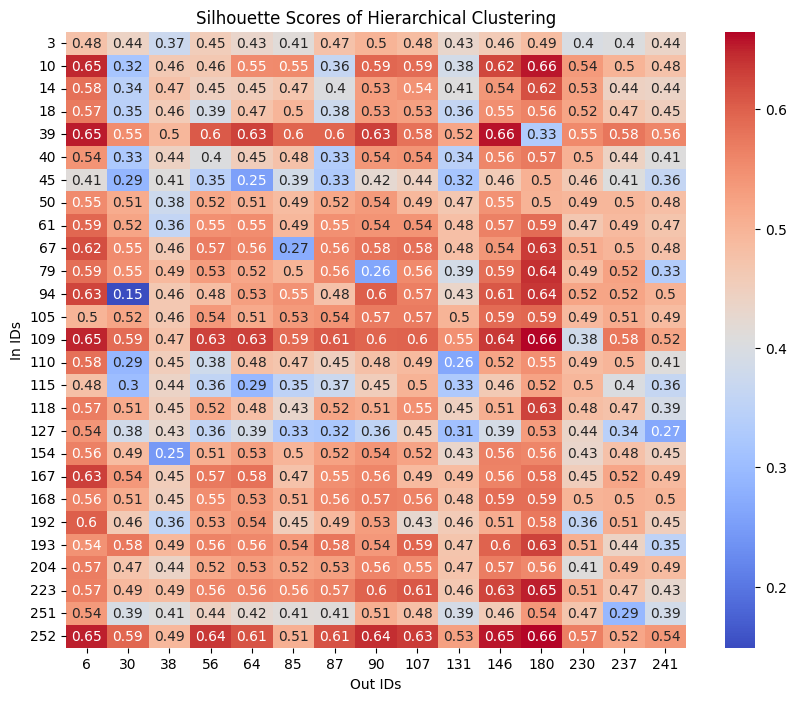

In [26]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the rest of your data loading and preprocessing is the same

# Define the number of clusters for hierarchical clustering
n_clusters = 2  # This can be adjusted based on your specific needs

# Prepare the silhouette_avg DataFrame
silhouette_avg = pd.DataFrame(index=unique_ids_in, columns=unique_ids_out)

# Apply Hierarchical Clustering
for id_in in unique_ids_in:
    for id_out in unique_ids_out:
        data_in = df_in[df_in['ID'] == id_in].iloc[:, 3:]
        data_out = df_out[df_out['ID'] == id_out].iloc[:, 3:]
        
        if not data_in.empty and not data_out.empty:
            data_cluster = pd.concat([data_in, data_out])

            # Perform Agglomerative (Hierarchical) Clustering
            hier_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
            hier_cluster.fit(data_cluster)

            # Calculate the silhouette score
            if len(data_cluster) > 1:
                score = silhouette_score(data_cluster, hier_cluster.labels_)
                silhouette_avg.at[id_in, id_out] = score

silhouette_avg = silhouette_avg.applymap(pd.to_numeric, errors='coerce')
# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(silhouette_avg, annot=True, cmap='coolwarm')
plt.title('Silhouette Scores of Hierarchical Clustering')
plt.xlabel('Out IDs')
plt.ylabel('In IDs')
plt.show()

In [ ]:
pd.set_option('display.max_rows', 100)  # Change 100 to whatever number you want


In [ ]:
df = pd.read_csv('solider_result.csv', nrows=200)

# Convert feature columns to floats
for col in df.columns[3:]:  # Adjust the index 3 based on your CSV structure
    df[col] = df[col].astype(float)

#df.head(100)

id_map = [
{
'id':[45,64],
},
{
'id':[67,85],
}
]


def map_ids_to_class_with_mapping(df, id_map):
    # Copy 'ID' column to a new 'class' column
    df['class'] = df['ID']
    
    # Iterate through the provided id_map
    for group in id_map:
        # Get the first ID in the list to use as the new class value
        new_class_value = group['id'][0]
        # For each ID in the 'id' list, set the new class value
        df.loc[df['ID'].isin(group['id']), 'class'] = new_class_value
    
    return df
new_df_mapped = map_ids_to_class_with_mapping(df, id_map)


# new_df_mapped[['ID','class']].head(100) 

#### Analsis pureza carpteas (Existe In y Out dentro de una carpeta?)

In [ ]:
### READ FOLDER
# entries = os.listdir('in-out/3')
# list = [img.split('_')[3] for img in entries]


### ANALISIS DE CARPETAS, IN, OUT, INOUT
folders = get_folders('in-out-backup')

result = {
    'in' : [],
    'out': [],
    'inout': []
}
count = 0
for folder in folders:
    list_images = os.listdir(folder)
    list = [img.split('_')[3] for img in list_images]
    results = in_out_status(list)
    if results == 'In':
        # continue
        result['in'].append(folder.split('/')[-1])
        count += 1
    elif results == 'Out':
        # continue
        result['out'].append(folder.split('/')[-1])
        count += 1
    else:
        result['inout'].append(folder.split('/')[-1])

print(result)
print(count)
# os.listdir()
# [f"{in_out_status(f)} {f.split('/')[-1]}" for f in folders]
# hola = [in_out_status([img.split('_')[3] for img in os.listdir(f)]) for f in folders]
# 


In [ ]:
# dataset_path = '/home/diego/Documents/DataSets/Data training entrada y salida'
# features_array, image_names = solider_result(dataset_path)
# save_solider_csv(features_array, image_names, 'dataset')